In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## Check Point 2

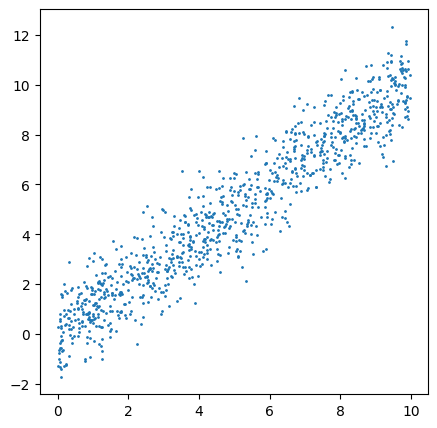

In [2]:
Y = []
X = []
for i in range(1000):
    # generating a random number from 0 to 10 uniform distribution
    x = np.random.uniform(0, 10)
    # generating a random number from standard normal distribution
    err = np.random.standard_normal()
    # calculating the value of y
    y = x + err
    Y.append(y)
    X.append(x)

# plotting the data
plt.figure(figsize=(5,5))
plt.scatter(X, Y, s=1)

## Implementing the Algorithm -> FCM + Bias field Correction

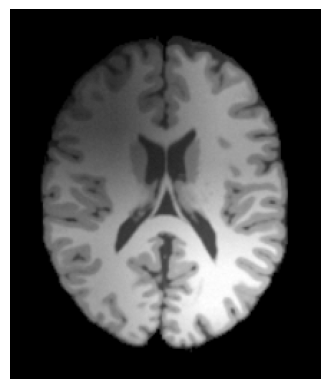

In [3]:
image = plt.imread('Brain_MRI.png')
# converting it ot gray scale image
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plotting the image
plt.axis('off')
plt.imshow(image, cmap='gray')

In [4]:
K = 3 # Number of clusters
q = 4 # fuzziness parameter

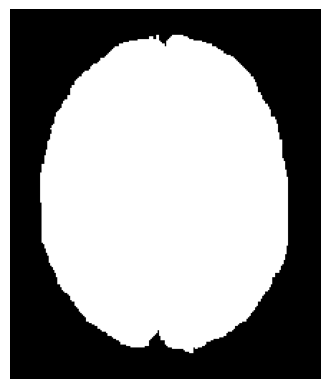

In [5]:
# not considering the background pixels for optimization 
flag = image > 0
plt.axis('off')
plt.imshow(flag, cmap='gray')

In [6]:
# initializing the memberships
memberships = np.random.rand(*image.shape, K)
memberships = memberships / np.sum(memberships, axis=2, keepdims=True)
memberships = memberships * flag[:,:,np.newaxis]


In [7]:
# initializing the bias field
bias_field = np.ones_like(image)
bias_field = bias_field * flag


In [8]:
# initializing the centroids
class_means = np.array([0.30000000, 0.65000000, 1.00000000])
class_means 

array([0.3 , 0.65, 1.  ])

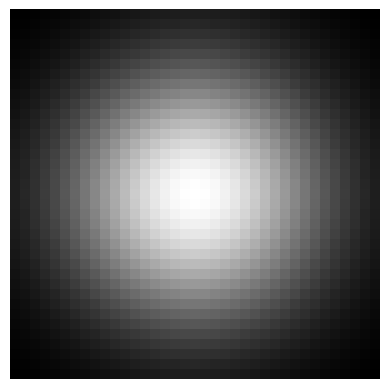

In [9]:
# weights for each pixel
size = 37
sigma = 3
x = np.linspace(-2*sigma, 2*sigma, size)
y = np.linspace(-2*sigma, 2*sigma, size)
X, Y = np.meshgrid(x, y)
weights = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
weights = weights / weights.sum()
plt.axis('off')
plt.imshow(weights, cmap='gray')

In [10]:
# storing the coordinates of considered pixels from the image
considered = []
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if flag[i,j]:
            considered.append((i,j))
print("Total :", image.shape[0]*image.shape[1])
print("Considered :", len(considered))

Total : 55986
Considered : 30370


In [11]:
# function for calculating the distances of each pixel from the class means (weighted)
def update_distances(image, class_means, weights, bias_field):
    x, y = weights.shape
    n = x // 2
    m = y // 2
    distances = np.zeros((*image.shape, K))
    for i,j in considered:
        for k in range(K):
            distances[i,j,k] = np.sum((weights * (image[i,j] - class_means[k]*bias_field[i-n:i+n+1, j-m:j+m+1] )**2) * flag[i-n:i+n+1, j-m:j+m+1])
    return distances

In [12]:
# calculates the objective function
def calculate_objective_function(distances, memberships):
    return np.sum(memberships**q * distances)   

In [13]:
# function for updating the memberships
def update_memberships(distances):
    p = 1/(q-1)
    memberships = np.zeros_like(distances)
    for i, j in considered:
        for k in range(K):
            memberships[i,j,k] = 1 / np.sum((distances[i,j,k] / distances[i,j])**p)
    return memberships

In [14]:
# function for updating the bias field
def update_bias_field(image, class_means, weights, memberships):
    x, y = weights.shape
    n = x // 2
    m = y // 2
    bias_field = np.zeros_like(image)
    uqc = memberships**q * class_means
    uqc_sum = np.sum(uqc, axis=2)
    uqc2 = np.sum(uqc * class_means, axis=2)
    for i,j in considered:
        bias_field[i,j] = np.sum((weights * image[i-n:i+n+1, j-m:j+m+1]) * uqc_sum[i-n:i+n+1, j-m:j+m+1])/np.sum(weights * uqc2[i-n:i+n+1, j-m:j+m+1])
    return bias_field

In [15]:
# function for updating the class means
def update_class_means(image, memberships, bias_field, weights):
    class_means = np.zeros(K)
    x, y = weights.shape
    n = x // 2
    m = y // 2
    for k in range(K-1):
        numerator = 0
        denominator = 0
        for i, j in considered:
            numerator += (memberships[i,j,k]**q * image[i,j]) * np.sum(weights * bias_field[i-n:i+n+1, j-m:j+m+1])
            denominator += (memberships[i,j,k]**q) * np.sum(weights * bias_field[i-n:i+n+1, j-m:j+m+1]**2)
        class_means[k] = numerator / denominator
    return class_means

In [16]:
# optimization loop
last_loss = 0
curr_loss = 0
for i in range(1000):
    distances = update_distances(image, class_means, weights, bias_field)
    memberships = update_memberships(distances)
    bias_field = update_bias_field(image, class_means, weights, memberships)
    class_means = update_class_means(image, memberships, bias_field, weights)
    last_loss = curr_loss
    curr_loss = calculate_objective_function(distances, memberships)
    print("i :", i, " Loss :", curr_loss)
    if np.abs(last_loss - curr_loss) < 0.1:
        break

i : 0  Loss : 36.36358617875243
i : 1  Loss : 44.860432237039575
i : 2  Loss : 31.489181772347113
i : 3  Loss : 27.064997376576322
i : 4  Loss : 24.633756232617728
i : 5  Loss : 22.995375880920527
i : 6  Loss : 21.738041378463237
i : 7  Loss : 20.70547767550705
i : 8  Loss : 19.85588803878058
i : 9  Loss : 19.193325430056493
i : 10  Loss : 18.720091647616222
i : 11  Loss : 18.4127649111168
i : 12  Loss : 18.22882987633253
i : 13  Loss : 18.124726902112098
i : 14  Loss : 18.067519903044662


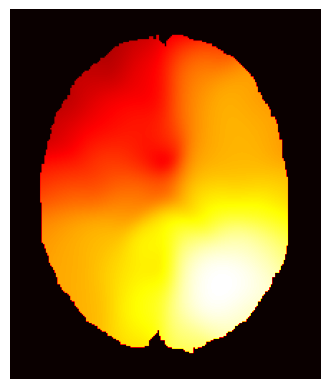

In [20]:
# return heat map pf the bias field
plt.axis('off')
plt.imshow(bias_field, cmap='hot')

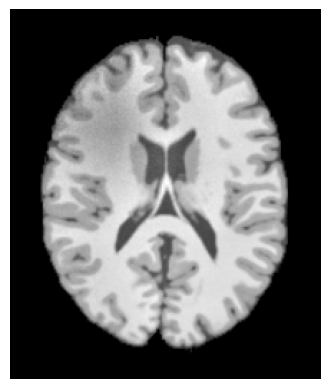

In [21]:
# dividing the original image by the bias field to get the corrected image
corrected_image = np.zeros_like(image) 
for i,j in considered:
    corrected_image[i,j] = image[i,j] / bias_field[i,j]
plt.axis('off')
plt.imshow(corrected_image, cmap='gray')

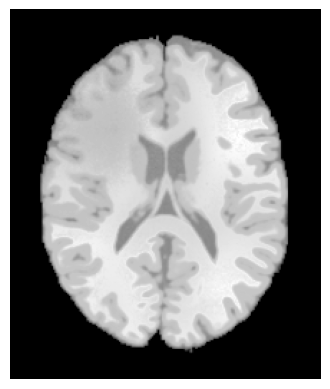

In [19]:
# replacing each pixel with the class mean
corrected_image1 = np.zeros_like(image)
for i,j in considered:
    corrected_image1[i,j] = np.sum(memberships[i,j] * class_means)
plt.axis('off')
plt.imshow(corrected_image1, cmap='gray')